# Modeling


### Importing libraries

In [1]:
import pandas as pd
pd.set_option("max_columns", 50)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from collections import OrderedDict, defaultdict
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Results data frame.
We create an empty data frame to store the obtained results with different algorithms.

In [2]:
modelizationResults = pd.DataFrame({'Algorithm': [], 
                                    'Fine_Tuning': [],
                                    'R2_Train': [], 
                                    'R2_Test': [], 
                                    'MAE_Train': [], 
                                    'MAE_Test': []})

### Convenience functions
We are going to create some functions to reduce the code:
* chartResults: Compares target with predicted data.
* histResults: Show the shape of the price distribution of predicted prices
* rowOfResults: Creates a show of results with the main metrics of train and test datasets to append to `modelizationResults` data frame.

In [3]:
def chartResults(y, predBest, trainTest, model=None):
    
    '''
    Example of use:
    chartResults(y=y_train, predBest=predTrain, trainTest='Train', model='Decision Trees')
    '''
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y, predBest, s=20,alpha=0.1)
    plt.title(model + '\nPredicted Price vs. Real Price. \n' + trainTest + ' dataset')
    plt.xlabel('Real Price')
    plt.ylabel('Predicted Price')
    plt.plot([min(y), max(y)], [min(y), max(y)], 'y')
    
#    return plt.tight_layout()
    return plt.show()

def histResults(trainPred, testPred):
    
    '''
    Example of use:
    histResults(trainPred=predKNNTrain, testPred=predKNNTest)
    '''
    
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(trainPred, bins=40)
    axes[0].set_title('Train data: predicted prices')
    axes[1].hist(testPred, bins=40)
    axes[1].set_title('Test data: predicted prices')
    
    return plt.show()

def rowOfResults(Algorithm, Fine_Tuning, R2_Train, R2_Test, MAE_Train, MAE_Test):
    '''
    Example:
    rowOfResults('Decision trees', True, 2, 3, 4, 5)
    '''
    tempResults = pd.DataFrame({'Algorithm': [Algorithm], 
                                'Fine_Tuning': [Fine_Tuning],
                                'R2_Train': [np.round(R2_Train, 3)],
                                'R2_Test': [np.round(R2_Test, 3)],
                                'MAE_Train': [np.round(MAE_Train, 0)],
                                'MAE_Test': [np.round(MAE_Test, 0)]})
    return tempResults

***

### Reading clean dataset
We will only load the features used in modelization. `postalCode` or `brand` and `model` won't be included. `kilometer` will be used in its original form, instead of categorical transformation applied in data cleaning process.

In [4]:
datasetCarsFinal = pd.read_csv('../data/autosFinal.csv',
                               usecols=[
                                      #'brand', 
                                      #'model', 
                                      'brandModel',
                                      'vehicleType', 
                                      'gearbox', 
                                      'yearOfRegistration',
                                      'fuelType',
                                      'powerPS',
                                      'kilometer',
                                      #'kilometerCategorical',
                                      #'kilometer000',
                                      'notRepairedDamage',
                                      #'postalCode',
                                      'state',
                                      'price'
                                      ],
                               dtype={
                                      #'brand': 'str', 
                                      #'model': 'str', 
                                      'brandModel': 'str', 
                                      'vehicleType': 'str', 
                                      'gearbox': 'str', 
                                      'yearOfRegistration': np.int64,
                                      'fuelType': 'str',
                                      'powerPS': np.int64,
                                      'kilometer': np.int64,
                                      #'kilometerCategorical': 'str',
                                      #'kilometer000': np.int64,
                                      'notRepairedDamage': 'str',
                                      #'postalCode': 'str',
                                      'state': 'str',
                                      'price': np.int64
                                      })

In [5]:
datasetCarsFinal.columns

Index(['state', 'brandModel', 'vehicleType', 'gearbox', 'fuelType',
       'notRepairedDamage', 'kilometer', 'powerPS', 'yearOfRegistration',
       'price'],
      dtype='object')

In [6]:
datasetCarsFinal.head()

,state,brandModel,vehicleType,gearbox,fuelType,notRepairedDamage,kilometer,powerPS,yearOfRegistration,price
0,Bayern,jeep grand,suv,automatik,diesel,nein,125000,163,2004,9800
1,Bayern,volkswagen golf,kleinwagen,manuell,benzin,nein,150000,75,2001,1500
2,Hessen,skoda fabia,kleinwagen,manuell,diesel,nein,90000,69,2008,3600
3,Nordrhein-Westfalen,bmw 3er,limousine,manuell,benzin,ja,150000,102,1995,650
4,Rheinland-Pfalz,peugeot 2_reihe,cabrio,manuell,benzin,nein,150000,109,2004,2200


***

## Data setup
### Splitting dataset into target, and numerical and categorical predictors
This is necessary in order to use LabelEncoder only on categorical features

In [7]:
target = datasetCarsFinal['price']
numerical = datasetCarsFinal[['yearOfRegistration', 'powerPS', 'kilometer']]
categorical = datasetCarsFinal.drop(['yearOfRegistration', 'powerPS', 'price', 'kilometer'], axis=1)

Now, we can apply Label encoder to each categorical column and rejoin columns in a new data frame

In [8]:
d = defaultdict(LabelEncoder)
categorical_encoded = categorical.apply(lambda x: d[x.name].fit_transform(x))
datasetCarsFinalConcat = pd.concat([categorical_encoded, numerical], axis=1)

In [9]:
datasetCarsFinalConcat.head()

,state,brandModel,vehicleType,gearbox,fuelType,notRepairedDamage,yearOfRegistration,powerPS,kilometer
0,1,91,6,0,2,1,2004,163,125000
1,1,236,3,1,0,1,2001,75,150000
2,6,206,3,1,2,1,2008,69,90000
3,9,21,5,1,0,0,1995,102,150000
4,10,174,1,1,0,1,2004,109,150000


For later use, we will save label encoding using joblib.

In [10]:
joblib.dump(d, '../output/carsLabelEncoder.pkl')

['../output/carsLabelEncoder.pkl']

### Create train and test datasets

In [11]:
np.random.seed(42)
train, test = train_test_split(datasetCarsFinalConcat.index, test_size = 0.2)

X_train = datasetCarsFinalConcat.loc[train]
y_train = target.loc[train]

X_test = datasetCarsFinalConcat.loc[test]
y_test = target.loc[test]

In [12]:
X_train.shape, y_train.shape 

((205178, 9), (205178,))

In [13]:
X_test.shape, y_test.shape

((51295, 9), (51295,))

Just one little chart to remember distribution of price in dataset:

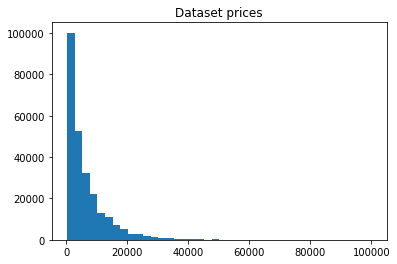

In [14]:
plt.hist(target, bins= 40)
plt.title('Dataset prices')
plt.show()

Now, data is ready for modeling

***

## Decision Trees
Our first try will be Decision Trees algorithm.  
No hyperparameters will be tuned for the moment:

In [15]:
regrDT = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [16]:
predDTTrain = regrDT.predict(X_train)
predDTTest = regrDT.predict(X_test)

### Distribution of predicted prices

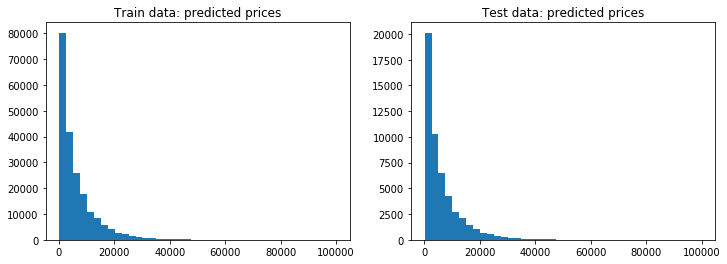

In [17]:
histResults(predDTTrain, predDTTest)

Predicted prices maintain the same shape than original data.

### Model scores:  

In [18]:
R2DTTrain = r2_score(y_train, predDTTrain)
R2DTTest = r2_score(y_test, predDTTest)
MAEDTTrain = mean_absolute_error(y_train, predDTTrain)
MAEDTTest = mean_absolute_error(y_test, predDTTest)

* $R^2$ & $MAE$ Score:

In [19]:
print('R2 Train: %.3f' % R2DTTrain, '\nR2 Test:  %.3f' % R2DTTest)
print('---------------')
print('MAE Train:', format(MAEDTTrain, ',f'), '\nMAE Test:', format(MAEDTTest, ',f'))

R2 Train: 0.989 
R2 Test:  0.863
---------------
MAE Train: 269.374334 
MAE Test: 1,278.372120


In [20]:
DTResults = rowOfResults('Decision trees', False, R2DTTrain, R2DTTest, MAEDTTrain, MAEDTTest)
DTResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,False,0.989,0.863,269.0,1278.0


In [21]:
modelizationResults = modelizationResults.append(DTResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0


Almost perfect with train data, but low $R²$ in test. Not bad results, but maybe some signals of overfitting.  
Let's go to some fine tuning on hyperparameters and cross validation to improve results.  

### Hyperparameter tuning

In [22]:
paramGridDT = {
        'criterion': ['mse'],
        'splitter': ['best', 'random'],
        'max_depth': list(range(1, 20 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1],
        'max_features': ['auto']
        }

**ATTENTION**: With this paramGrid cross validation takes 2 minutes to complete (has been commented on purpose).

In [23]:
#cvDT = GridSearchCV(
#        estimator = tree.DecisionTreeRegressor(),
#        param_grid=paramGridDT,
#        n_jobs=-1,
#        cv=10,
#        refit=False,
#        verbose=1,
#        return_train_score=True).fit(X_train, y_train)

In [24]:
#joblib.dump(cvDT, filename='../output/cvDT.pkl')

In [25]:
cvDT = joblib.load(filename='../output/cvDT.pkl')

These are the best parameters:

In [26]:
cvDT.best_params_

{'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'splitter': 'best'}

In [27]:
bestDecisionTree = tree.DecisionTreeRegressor(criterion=cvDT.best_params_['criterion'],
                                              max_depth=cvDT.best_params_['max_depth'],
                                              max_features=cvDT.best_params_['max_features'],
                                              min_samples_leaf=cvDT.best_params_['min_samples_leaf'],
                                              min_samples_split=cvDT.best_params_['min_samples_split'],
                                              splitter=cvDT.best_params_['splitter']).fit(X_train, y_train)

In [28]:
predBestDTTrain = bestDecisionTree.predict(X_train)
predBestDTTest = bestDecisionTree.predict(X_test)

### Distribution of predicted prices

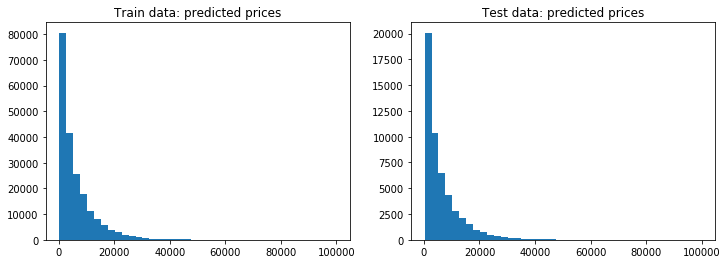

In [29]:
histResults(predBestDTTrain, predBestDTTest)

And the scores now are:

* $R^2$ & $MAE$ Score:

In [30]:
R2BestDTTrain = r2_score(y_train, predBestDTTrain)
R2BestDTTest = r2_score(y_test, predBestDTTest)
MAEBestDTTrain = mean_absolute_error(y_train, predBestDTTrain)
MAEBestDTTest = mean_absolute_error(y_test, predBestDTTest)

In [31]:
print('R2 Train: %.3f' % R2BestDTTrain, '\nR2 Test: %.3f' % R2BestDTTest)
print('---------------')
print('MAE Train:', format(MAEBestDTTrain, ',f'), '\nMAE Test:', format(MAEBestDTTest, ',f'))

R2 Train: 0.943 
R2 Test: 0.883
---------------
MAE Train: 925.500379 
MAE Test: 1,263.393346


In [32]:
DTBestResults = rowOfResults('Decision trees', True, R2BestDTTrain, R2BestDTTest, MAEBestDTTrain, MAEBestDTTest)
DTBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,True,0.943,0.883,926.0,1263.0


In [33]:
modelizationResults = modelizationResults.append(DTBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0


We have improved slightly test results but losing precision in train data.

## Charting results

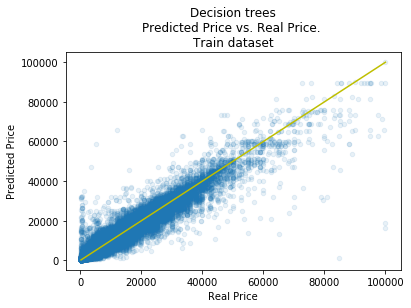

In [34]:
chartResults(y=y_train, predBest=predBestDTTrain, trainTest='Train', model='Decision trees')

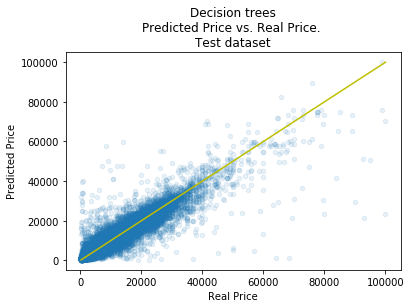

In [35]:
chartResults(y=y_test, predBest=predBestDTTest, trainTest='Test', model='Decision trees')

Algorithm sometimes fails predicting expensive cars (> 40000 €). As we can see at charts, model tends to underestimate them.

Importance of features:

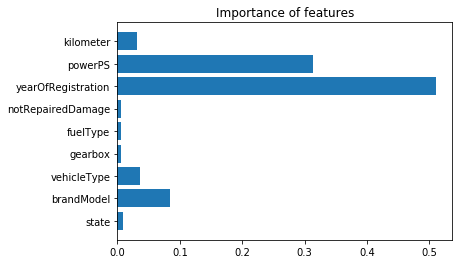

In [36]:
plt.barh(X_train.columns, bestDecisionTree.feature_importances_)
plt.title('Importance of features')
plt.show()

Using decision trees, only two features are the most important in model results: `powerPS` and `yearOfRegistration`. Importance of all others is below 10%.

### Saving the model for later use

In [37]:
joblib.dump(bestDecisionTree, filename='../output/bestDecisionTree.pkl')

['../output/bestDecisionTree.pkl']

***

# Random forest
Random forest will be the second algorithm we are going to use in order to improve results obtained with Decision Trees. Let's try to model without hyperparamenter tuning first.

In [38]:
regrRF = RandomForestRegressor(n_jobs=-1,
                               verbose=1).fit(X_train,
                                              y_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


In [39]:
predRFTrain = regrRF.predict(X_train)
predRFTest = regrRF.predict(X_test)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


### Distribution of predicted prices

We obtain a similar distribution of predicted prices than targeted prices.

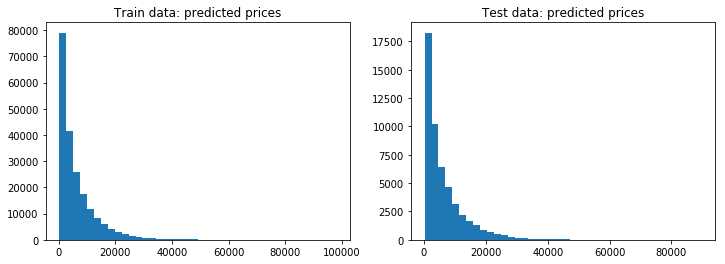

In [40]:
histResults(predRFTrain, predRFTest)

### Model scores:  

In [41]:
R2RFTrain = r2_score(y_train, predRFTrain)
R2RFTest = r2_score(y_test, predRFTest)
MAERFTrain = mean_absolute_error(y_train, predRFTrain)
MAERFTest = mean_absolute_error(y_test, predRFTest)

* $R^2$ & $MAE$ Score:

In [42]:
print('R2 Train: %.3f' % R2RFTrain, '\nR2 Test:  %.3f' % R2RFTest)
print('---------------')
print('MAE Train:', format(MAERFTrain, ',f'), '\nMSE Test:', format(MAERFTest, ',f'))

R2 Train: 0.975 
R2 Test:  0.907
---------------
MAE Train: 571.555842 
MSE Test: 1,131.579245


In [43]:
RFResults = rowOfResults('Random Forest', False, R2RFTrain, R2RFTest, MAERFTrain, MAERFTest)
RFResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Random Forest,False,0.975,0.907,572.0,1132.0


In [44]:
modelizationResults = modelizationResults.append(RFResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0


Despite random forest prediction with train data is not better than decision trees, test data predictions are, for the moment, the best. Let's see if some hyperparameter tuning is able to improve results.

### Hyperparameter tuning
We are going to determine the optimum number of features  and the number of estimators to include in the model:

* Max of features:

In [45]:
np.random.seed(123)
scores = {}

rf = None

for max_features in [2,4,8, 'auto', None]:
    if rf is None:
        rf = RandomForestRegressor(n_estimators=50,
                                   max_features=max_features)
    else:
        rf.warm_start = False
        rf.max_features = max_features
    
    rf = rf.fit(X_train, y_train)
    scores[max_features] = rf.score(X_test, y_test)

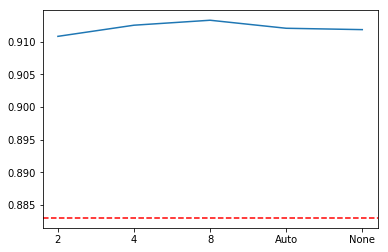

In [46]:
plt.plot([2, 4, 8, 'Auto', 'None'], scores.values())
plt.axhline(bestDecisionTree.score(X_test, y_test), linestyle='dashed', color='red')
plt.show()

8 is the best number of features to use in model

* Number of estimators:

In [47]:
np.random.seed(123)
scores = {}

rf = None

for n_estimators in [50, 100, 150, 200, 300, 500]:
    if rf is None:
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   max_features=8)
    else:
        rf.warm_start = False
        rf.n_estimators = n_estimators
    
    rf = rf.fit(X_train, y_train)
    scores[n_estimators] = rf.score(X_test, y_test)

In [48]:
scores

{50: 0.9129754664983755,
 100: 0.9139467004677101,
 150: 0.9142714538810123,
 200: 0.9146830301814439,
 300: 0.9145307500554084,
 500: 0.9149567384548523}

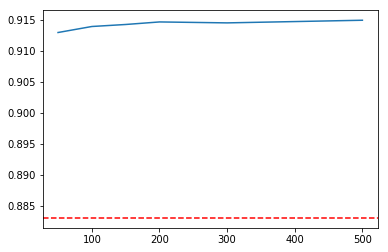

In [49]:
plt.plot([50, 100, 150, 200, 300, 500], scores.values())
plt.axhline(bestDecisionTree.score(X_test, y_test), linestyle='dashed', color='red')
plt.show()

500 estimators provide the best results, so we are going to use them combined with 8 features and the rest of hyperparameters.

In [50]:
paramsRF = {
        'n_estimators': [500],
        'max_features': [8],
        'max_depth': list(range(1, 10 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf':[1]
        }

**ATTENTION** This cross validation takes 2 hours to complete (has been commented on purpose).

In [51]:
#cvRF = GridSearchCV(
#        estimator=RandomForestRegressor(oob_score=True),
#        param_grid=paramsRF,
#        n_jobs=-1,
#        cv=10,
#        verbose=1,
#        return_train_score=True).fit(X_train, y_train)

In [52]:
#joblib.dump(cvRF, filename='../output/cvRF.pkl')

In [53]:
cvRF = joblib.load(filename='../output/cvRF.pkl')

In [54]:
cvRF.best_params_

{'max_depth': 10,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [55]:
bestRandomForest = RandomForestRegressor(max_depth=cvRF.best_params_['max_depth'], 
                                        max_features=cvRF.best_params_['max_features'], 
                                        min_samples_leaf=cvRF.best_params_['min_samples_leaf'], 
                                        min_samples_split=cvRF.best_params_['min_samples_split'], 
                                        n_estimators=cvRF.best_params_['n_estimators']).fit(X_train, y_train)

In [56]:
predBestRFTrain = bestRandomForest.predict(X_train)
predBestRFTest = bestRandomForest.predict(X_test)

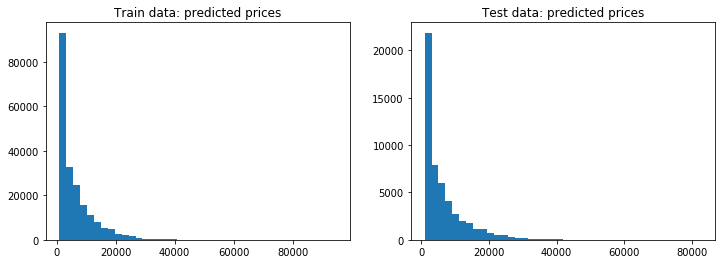

In [57]:
histResults(predBestRFTrain, predBestRFTest)

### Model scores:  

In [58]:
R2BestRFTrain = r2_score(y_train, predBestRFTrain)
R2BestRFTest = r2_score(y_test, predBestRFTest)
MAEBestRFTrain = mean_absolute_error(y_train, predBestRFTrain)
MAEBestRFTest = mean_absolute_error(y_test, predBestRFTest)

* $R^2$ & $MAE$ Score:

In [59]:
print('R2 Train: %.3f' % R2BestRFTrain, '\nR2 Test: %.3f' % R2BestRFTest)
print('--------------')
print('MAE Train:', format(MAEBestRFTrain, ',f'), '\nMAE Test:', format(MAEBestRFTest, ',f'))

R2 Train: 0.897 
R2 Test: 0.881
--------------
MAE Train: 1,382.071307 
MAE Test: 1,444.832311


In [60]:
RFBestResults = rowOfResults('Random Forest', True, R2BestRFTrain, R2BestRFTest, MAEBestRFTrain, MAEBestRFTest)
RFBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Random Forest,True,0.897,0.881,1382.0,1445.0


In [61]:
modelizationResults = modelizationResults.append(RFBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0


Fine tuning of random forest is not getting the best results, but error levels are very similar between train and test data.

## Charting results

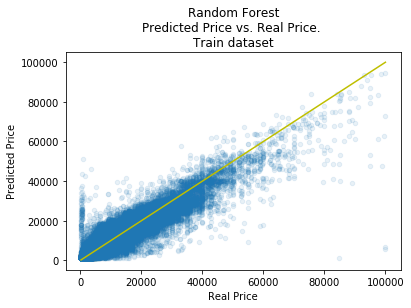

In [62]:
chartResults(y=y_train, predBest=predBestRFTrain, trainTest='Train', model='Random Forest')

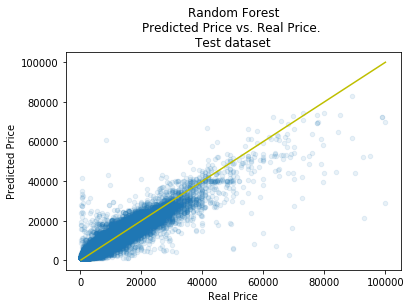

In [63]:
chartResults(y=y_test, predBest=predBestRFTest, trainTest='Test', model='Random Forest')

Same problem predicting expensive cars. Random Forest underestimates them too.

Features importance:

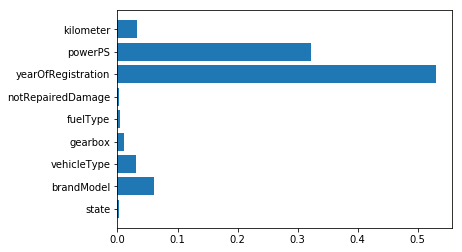

In [64]:
plt.barh(X_train.columns, bestRandomForest.feature_importances_)
plt.show()

`yearOfRegistration` and `powerPS` are the most important features in random forest model, like we saw using decision trees.

### Saving the model for later use

In [65]:
joblib.dump(bestRandomForest, filename='../output/bestRandomForest.pkl')

['../output/bestRandomForest.pkl']

***

# K-nearest neighbours

First try, no hyperparameter tuning

In [66]:
regrKNN = neighbors.KNeighborsRegressor(n_jobs=-1).fit(X_train, y_train)

In [67]:
predKNNTrain = regrKNN.predict(X_train)
predKNNTest = regrKNN.predict(X_test)

### Distribution of predicted prices

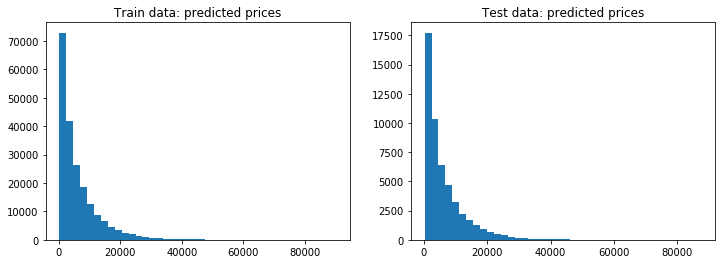

In [68]:
histResults(predKNNTrain, predKNNTest)

### Model score:  

In [69]:
R2KNNTrain = r2_score(y_train, predKNNTrain)
R2KNNTest = r2_score(y_test, predKNNTest)
MAEKNNTrain = mean_absolute_error(y_train, predKNNTrain)
MAEKNNTest = mean_absolute_error(y_test, predKNNTest)

* $R^2$ & $MAE$ Score:

In [70]:
print('R2 Train: %.3f' % R2KNNTrain, '\nR2 Test:  %.3f' % R2KNNTest)
print('---------------')
print('MAE Train:', format(MAEKNNTrain, ',f'), '\nMAE Test:', format(MAEKNNTest, ',f'))

R2 Train: 0.900 
R2 Test:  0.839
---------------
MAE Train: 1,130.565695 
MAE Test: 1,444.801653


In [71]:
KNNResults = rowOfResults('K-nearest neighbours', False, R2KNNTrain, R2KNNTest, MAEKNNTrain, MAEKNNTest)
KNNResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,K-nearest neighbours,False,0.9,0.839,1131.0,1445.0


In [72]:
modelizationResults = modelizationResults.append(KNNResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0
0,K-nearest neighbours,0.0,0.900,0.839,1131.0,1445.0


### Hyperparameter tuning

In [73]:
paramsKNN = {
        'n_neighbors': [5, 10, 20],
        'weights': ['distance', 'uniform'],
        'algorithm': ['auto'],
        'leaf_size': [2,3,4],
        }

**ATTENTION**: This cross validation takes 1 hour (has been commented on purpose)

In [74]:
#cvKNN = GridSearchCV(
#        estimator=neighbors.KNeighborsRegressor(),
#        param_grid=paramsKNN,
#        n_jobs=-1,
#        cv=10,
#        verbose=1,
#        return_train_score=True).fit(X_train, y_train)

In [75]:
#joblib.dump(cvKNN, filename='../output/cvKNN.pkl')

In [76]:
cvKNN = joblib.load(filename='../output/cvKNN.pkl')

In [77]:
cvKNN.best_params_

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5, 'weights': 'distance'}

In [78]:
bestKNN = neighbors.KNeighborsRegressor(algorithm=cvKNN.best_params_['algorithm'], 
                                        leaf_size=cvKNN.best_params_['leaf_size'],
                                        n_neighbors=cvKNN.best_params_['n_neighbors'],
                                        weights=cvKNN.best_params_['weights']).fit(X_train, y_train)

In [79]:
predBestKNNTrain = bestKNN.predict(X_train)
predBestKNNTest = bestKNN.predict(X_test)

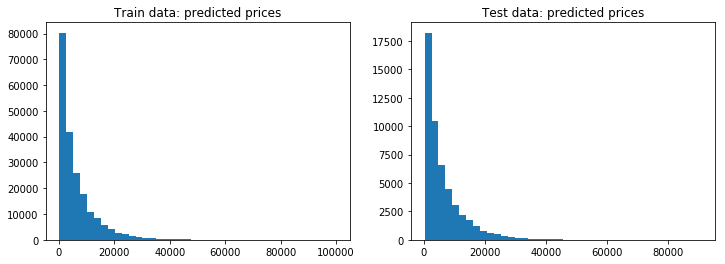

In [80]:
histResults(predBestKNNTrain, predBestKNNTest)

### Model score:  

In [81]:
R2BestKNNTrain = r2_score(y_train, predBestKNNTrain)
R2BestKNNTest = r2_score(y_test, predBestKNNTest)
MAEBestKNNTrain = mean_absolute_error(y_train, predBestKNNTrain)
MAEBestKNNTest = mean_absolute_error(y_test, predBestKNNTest)

* $R^2$ & $MAE$ Score:

In [82]:
print('R2 Train: %.3f' % R2BestKNNTrain, '\nR2 Test: %.3f' % R2BestKNNTest)
print('-------------')
print('MAE Train:', format(MAEBestKNNTrain, ',f'), '\nMAE Test:', format(MAEBestKNNTest, ',f'))

R2 Train: 0.989 
R2 Test: 0.860
-------------
MAE Train: 272.981820 
MAE Test: 1,276.165070


In [83]:
KNNBestResults = rowOfResults('K-nearest neighbours', True, R2BestKNNTrain, R2BestKNNTest, MAEBestKNNTrain, MAEBestKNNTest)
KNNBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,K-nearest neighbours,True,0.989,0.86,273.0,1276.0


In [84]:
modelizationResults = modelizationResults.append(KNNBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0
0,K-nearest neighbours,0.0,0.900,0.839,1131.0,1445.0
0,K-nearest neighbours,1.0,0.989,0.860,273.0,1276.0


Tuned K-nearest neighbours presents an important difference in train and test error levels. Maybe, signal of some overfitting.

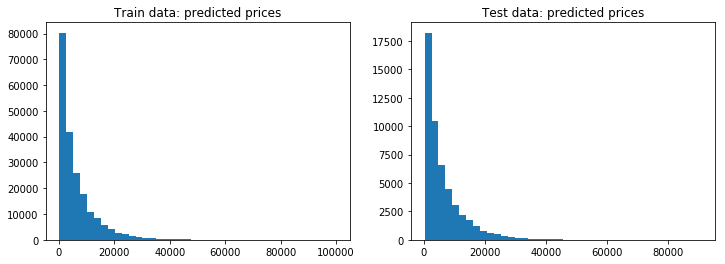

In [85]:
histResults(predBestKNNTrain, predBestKNNTest)

## Charting results
Train data

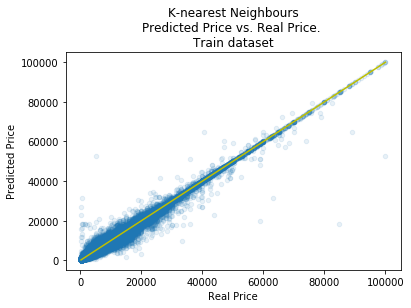

In [86]:
chartResults(y=y_train, predBest=predBestKNNTrain, trainTest='Train', model='K-nearest Neighbours')

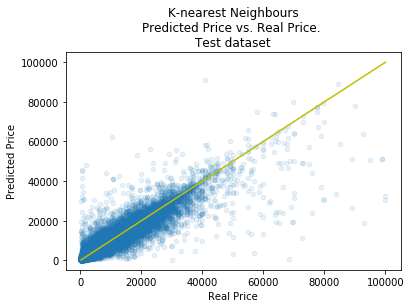

In [87]:
chartResults(y=y_test, predBest=predBestKNNTest, trainTest='Test', model='K-nearest Neighbours')

Same behaviour we saw with previous algorithms. Cars above 40K€ are underestimated.

### Saving the model for later use

In [88]:
joblib.dump(bestKNN, filename='../output/bestKNN.pkl')

['../output/bestKNN.pkl']

***

# Gradient boosting

No hyperparameters tuning for the moment.

In [89]:
regrBoost = GradientBoostingRegressor().fit(X_train, y_train)

In [90]:
predBoostTrain = regrBoost.predict(X_train)
predBoostTest = regrBoost.predict(X_test)

### Distribution of predicted prices

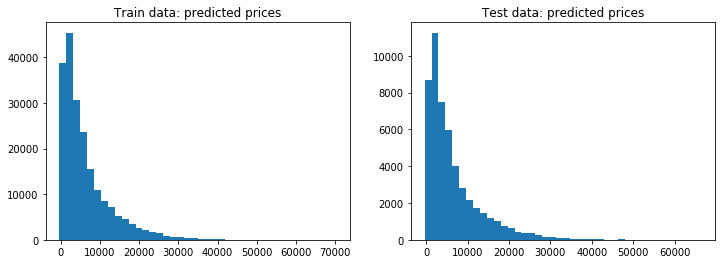

In [91]:
histResults(predBoostTrain, predBoostTest)

### Model score:  

In [92]:
R2BoostTrain = r2_score(y_train, predBoostTrain)
R2BoostTest = r2_score(y_test, predBoostTest)
MAEBoostTrain = mean_absolute_error(y_train, predBoostTrain)
MAEBoostTest = mean_absolute_error(y_test, predBoostTest)

* $R^2$ & $MAE$ Score:

In [93]:
print('R2 Train: %.3f' % R2BoostTrain, '\nR2 Test:  %.3f' % R2BoostTest)
print('-------------')
print('MAE Train:', format(MAEBoostTrain, ',f'), '\nMAE Test:', format(MAEBoostTest, ',f'))

R2 Train: 0.847 
R2 Test:  0.836
-------------
MAE Train: 1,519.448349 
MAE Test: 1,556.380762


In [94]:
BoostResults = rowOfResults('Gradient Boosting', False, R2BoostTrain, R2BoostTest, MAEBoostTrain, MAEBoostTest)
BoostResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Gradient Boosting,False,0.847,0.836,1519.0,1556.0


In [95]:
modelizationResults = modelizationResults.append(BoostResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0
0,K-nearest neighbours,0.0,0.900,0.839,1131.0,1445.0
0,K-nearest neighbours,1.0,0.989,0.860,273.0,1276.0
0,Gradient Boosting,0.0,0.847,0.836,1519.0,1556.0


Not very nice results. It would be necessary to tune parameters.

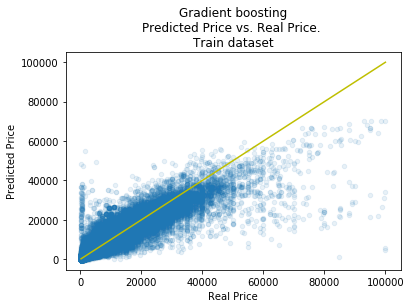

In [96]:
chartResults(y=y_train, predBest=predBoostTrain, trainTest='Train', model='Gradient boosting')

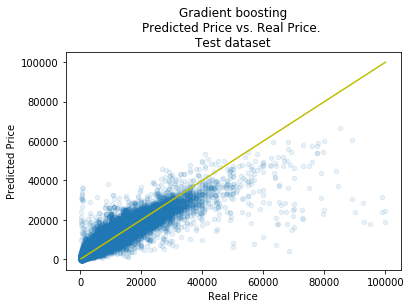

In [97]:
chartResults(y=y_test, predBest=predBoostTest, trainTest='Test', model='Gradient boosting')

We can observe a bias in the results as the real price increases.

### Hyperparameter tuning

**ATTENTION**: This cross validation takes 3 hours to complete (has been commented on purpose)

In [98]:
paramsBoost = {
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [100, 200, 500],
        'max_depth': [1, 3, 5],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': [None, 'auto']
        }

In [99]:
#cvBoost = GridSearchCV(
#        estimator=GradientBoostingRegressor(),
#        param_grid=paramsBoost,
#        n_jobs=-1,
#        cv=10,
#        verbose=1,
#        return_train_score=True).fit(X_train, y_train)

In [100]:
#joblib.dump(cvBoost, filename='../output/cvBoost.pkl')

In [101]:
cvBoost = joblib.load(filename='../output/cvBoost.pkl')

In [102]:
cvBoost.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [103]:
bestBoost = GradientBoostingRegressor(learning_rate=cvBoost.best_params_['learning_rate'],
                                      max_depth=cvBoost.best_params_['max_depth'],
                                      max_features=cvBoost.best_params_['max_features'],
                                      min_samples_leaf=cvBoost.best_params_['min_samples_leaf'],
                                      min_samples_split=cvBoost.best_params_['min_samples_split'],
                                      n_estimators=cvBoost.best_params_['n_estimators']).fit(X_train, y_train)

In [104]:
predBestBoostTrain = bestBoost.predict(X_train)
predBestBoostTest = bestBoost.predict(X_test)

### Model score:  

In [105]:
R2BestBoostTrain = r2_score(y_train, predBestBoostTrain)
R2BestBoostTest = r2_score(y_test, predBestBoostTest)
MAEBestBoostTrain = mean_absolute_error(y_train, predBestBoostTrain)
MAEBestBoostTest = mean_absolute_error(y_test, predBestBoostTest)

* $R^2$ & $MAE$ Score:

In [106]:
print('R2 Train: %.3f' % R2BestBoostTrain, '\nR2 Test: %.3f' % R2BestBoostTest)
print('------------')
print('MAE Train:', format(MAEBestBoostTrain, ',f'), '\nMAE Test:', format(MAEBestBoostTest, ',f'))

R2 Train: 0.931 
R2 Test: 0.911
------------
MAE Train: 1,108.476725 
MAE Test: 1,172.294428


In [107]:
BoostBestResults = rowOfResults('Gradient Boosting', True, R2BestBoostTrain, R2BestBoostTest, MAEBestBoostTrain, MAEBestBoostTest)
BoostBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Gradient Boosting,True,0.931,0.911,1108.0,1172.0


Now results are much better than detuned boosting model.

The final table of results will allow us to decide which algorithm will be finally chosen for predicting prices

In [108]:
modelizationResults = modelizationResults.append(BoostBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0
0,K-nearest neighbours,0.0,0.900,0.839,1131.0,1445.0
0,K-nearest neighbours,1.0,0.989,0.860,273.0,1276.0
0,Gradient Boosting,0.0,0.847,0.836,1519.0,1556.0
0,Gradient Boosting,1.0,0.931,0.911,1108.0,1172.0


<BarContainer object of 9 artists>

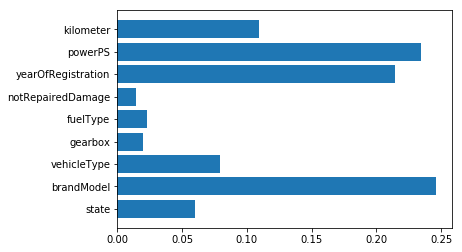

In [109]:
plt.barh(X_train.columns, bestBoost.feature_importances_)

Gradient boosting gives `brandModel` variable the most contribution in the model explanation (followed by `powerPS`, `yearOfRegistration` or `kilometer`). It makes sense according to general knowledge of cars market: in equal conditions for some features, some brands are more expensive than others.  
So we can conclude that gradient boosting is the algorithm that is better able to predict the price of the cars of the dataset, so it will be used to predict new prices in our application.

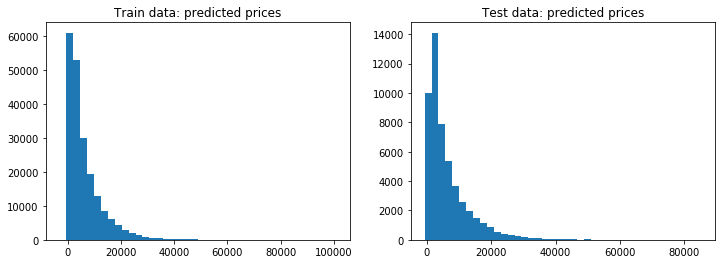

In [110]:
histResults(predBestBoostTrain, predBestBoostTest)

## Charting results

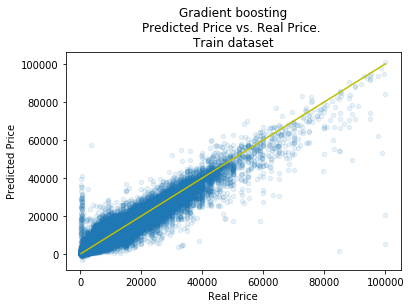

In [111]:
chartResults(y=y_train, predBest=predBestBoostTrain, trainTest='Train', model='Gradient boosting')

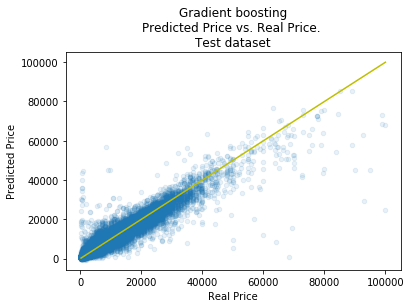

In [112]:
chartResults(y=y_test, predBest=predBestBoostTest, trainTest='Test', model='Gradient boosting')

### Saving the model for later use

In [113]:
joblib.dump(bestBoost, filename='../output/bestBoost.pkl')

['../output/bestBoost.pkl']

***

### Saving the results data frame

In [114]:
joblib.dump(modelizationResults, filename='../output/modelizationResults.pkl')
modelizationResults.to_csv(path_or_buf='../output/modelizationResults.csv')

***

# Testing things

In [115]:
bestDecisionTree = joblib.load('../output/bestDecisionTree.pkl')
bestRandomForest = joblib.load('../output/bestRandomForest.pkl')
bestKNN = joblib.load('../output/bestKNN.pkl')
bestBoost = joblib.load('../output/bestBoost.pkl')

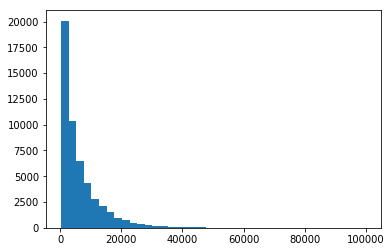

In [116]:
y_DT = bestDecisionTree.predict(X_test)
y_DT
plt.hist(y_DT, bins=40)
plt.show()

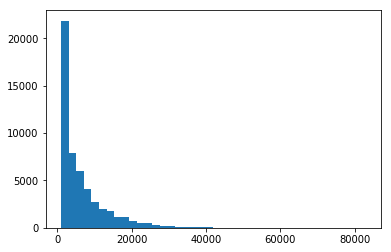

In [117]:
y_RF = bestRandomForest.predict(X_test)
y_RF
plt.hist(y_RF, bins=40)
plt.show()

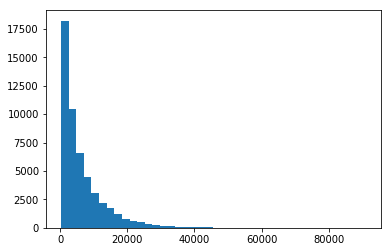

In [118]:
y_KNN = bestKNN.predict(X_test)
y_KNN
plt.hist(y_KNN, bins=40)
plt.show()

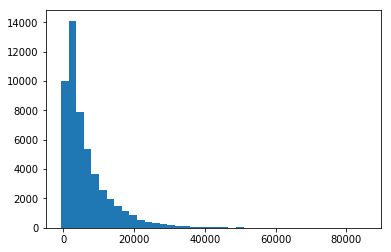

In [119]:
y_Boost = bestBoost.predict(X_test)
y_Boost
plt.hist(y_Boost, bins=40)
plt.show()

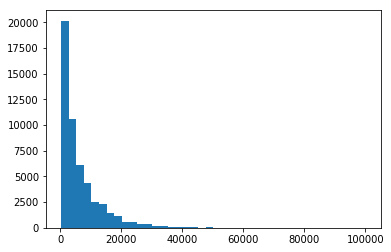

In [120]:
plt.hist(y_test, bins=40)
plt.show()

In [121]:
res = joblib.load('../output/modelizationResults.pkl')
res

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.989,0.863,269.0,1278.0
0,Decision trees,1.0,0.943,0.883,926.0,1263.0
0,Random Forest,0.0,0.975,0.907,572.0,1132.0
0,Random Forest,1.0,0.897,0.881,1382.0,1445.0
0,K-nearest neighbours,0.0,0.900,0.839,1131.0,1445.0
0,K-nearest neighbours,1.0,0.989,0.860,273.0,1276.0
0,Gradient Boosting,0.0,0.847,0.836,1519.0,1556.0
0,Gradient Boosting,1.0,0.931,0.911,1108.0,1172.0


In [122]:
boostPrices = pd.DataFrame({'Real prices': y_test,
                           'PredPrices': y_Boost})
boostPrices.head(20)

,Real prices,PredPrices
92951,2500,1975.425860
48752,12900,13681.162067
140519,3150,3655.369417
72552,699,555.517898
184899,2400,2340.607870
116559,3499,1710.156558
20818,3949,3953.873915
159058,3499,3283.608376
239197,4500,3322.006809
71682,5900,5810.505096


In [123]:
X_test.loc[92951]

state                      6
brandModel               240
vehicleType                5
gearbox                    1
fuelType                   0
notRepairedDamage          1
yearOfRegistration      1998
powerPS                  101
kilometer             125000
Name: 92951, dtype: int64